# Discrete Probabilistic Methods

## Exercise

Use basic probability to identify anomalous requests. Using the methods covered in this lesson, examine the rest of the features in the api access logs data set.

## 1. 

Wrangle Data

In [1]:
from env import get_data, iqr_bounds, check_columns
import env

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics

In [2]:
# query = """SELECT * FROM api_access"""

# log = get_data('logs', query, 'api_access')

## Stuff the Exercise Gave Us

In [3]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/logs'   
df = pd.read_sql('SELECT * FROM api_access', url)
# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


### Make Fake Entries to "detect"

In [4]:
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = pd.concat([df,new])

### Make a size_mb column

In [5]:
df['size_mb'] = df['size'] / 1024 / 1024

### Exploration

In [6]:
df.ip.value_counts().head()

ip
97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
Name: count, dtype: int64

In [7]:
df.ip.value_counts(normalize=True).head()

ip
97.105.19.58      0.858420
173.173.113.51    0.075762
72.181.113.170    0.043855
72.181.105.81     0.017599
68.201.219.223    0.001502
Name: proportion, dtype: float64

In [8]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )

In [9]:
ip_df = value_counts_and_frequencies(df.ip)
ip_df.head()

,count,proba
ip,,
97.105.19.58,11999,0.858420
173.173.113.51,1059,0.075762
72.181.113.170,613,0.043855
72.181.105.81,246,0.017599
68.201.219.223,21,0.001502


<Axes: ylabel='ip'>

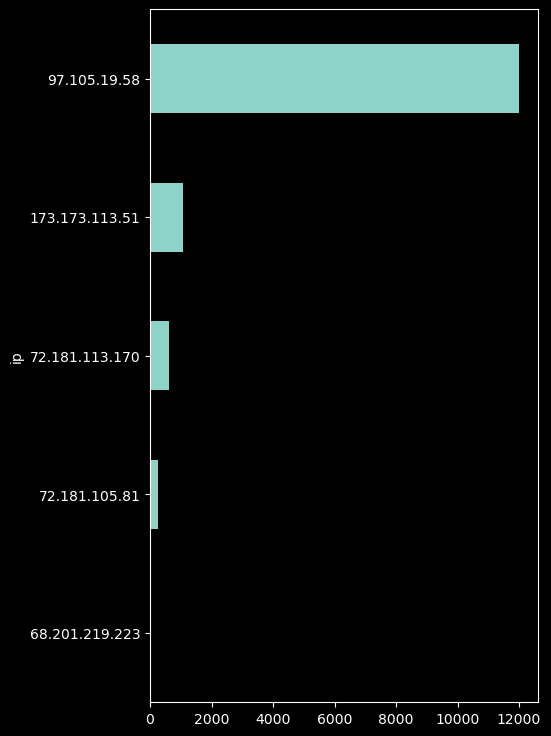

In [10]:
ip_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))

In [11]:
status_given_ip = (
    df.groupby('ip')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)
status_given_ip.head()

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.0
1,24.26.242.9,200,1.0
2,3.88.129.158,200,1.0
3,3.92.201.136,200,1.0
4,34.207.64.242,200,1.0


In [12]:
status_given_ip[status_given_ip.status_code != '200']

,ip,status_code,proba_status_given_ip
18,72.181.113.170,499,0.003263
19,95.31.16.121,301,1.000000
21,97.105.15.120,301,1.000000
23,97.105.19.58,499,0.001167


In [13]:
df[df.ip == '97.105.15.120']

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent,size_mb
2,97.105.15.120,18/Apr/2019 19:42:41,GET,/api/v1/sales?page=79/,HTTP/1.1,301,2560,python-requests/2.21.0,0.002441


In [14]:
status_given_ip[status_given_ip.proba_status_given_ip < 1]

,ip,status_code,proba_status_given_ip
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
22,97.105.19.58,200,0.998833
23,97.105.19.58,499,0.001167


## My Exploration

Total rows: 13978
Total columns: 9


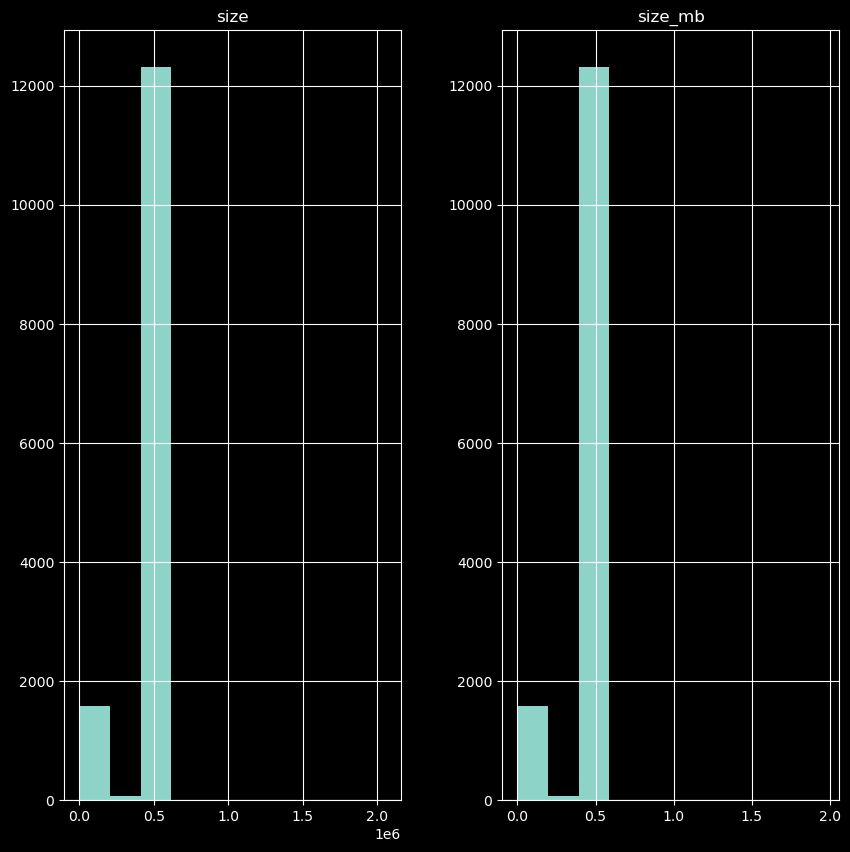

,col_name,dtype,num_unique,num_null,pct_null,unique_values,"range (min, max, mean)"
0,index,int64,13974,0,0.0,"Index([ 0, 1, 2, 3, 4, ...","(0, 13973)"
1,ip,object,22,0,0.0,"[97.105.19.58, 3.92.201.136, 52.90.165.200, 3....",None
2,timestamp,object,9957,0,0.0,"[16/Apr/2019 19:34:42, 16/Apr/2019 19:34:44, 1...",None
3,request_method,object,1,0,0.0,[GET],None
4,request_path,object,220,0,0.0,"[/api/v1/sales?page=81, /api/v1/items, /api/v1...",None
5,http_version,object,1,0,0.0,[HTTP/1.1],None
6,status_code,object,3,0,0.0,"[200, 499, 301]",None
7,size,int64,191,0,0.0,"[512495, 3561, 510103, 510003, 511963, 1328, 5...","(0, 2056327, 450001.91)"
8,user_agent,object,9,0,0.0,"[python-requests/2.21.0, Mozilla/5.0 (Macintos...",None
9,size_mb,float64,191,0,0.0,"[0.4887533187866211, 0.0033960342407226562, 0....","(0.0, 1.9610662460327148, 0.43)"


In [15]:
env.check_columns(df, graphs=True)

In [16]:
# Make status_desc column
    # 200 = success
    # 499 = client closed request
    # 301 = page permanently moved
    
df['status_desc'] = df.status_code.apply(lambda x: 'success' if x == '200' else 'redirection' if x == '301' else 'client_error')

Error: Could not generate box plot for column ip. Skipping to next column...
Error: Could not generate box plot for column timestamp. Skipping to next column...
Error: Could not generate box plot for column request_method. Skipping to next column...
Error: Could not generate box plot for column request_path. Skipping to next column...
Error: Could not generate box plot for column http_version. Skipping to next column...
Error: Could not generate box plot for column status_code. Skipping to next column...


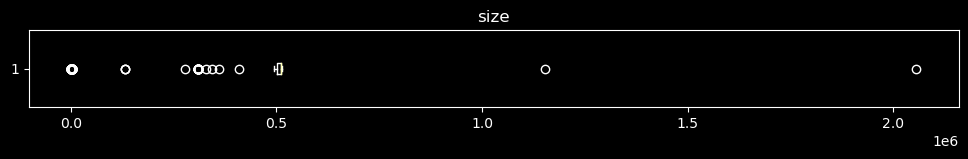

Number of results in lower quartile: 1658 (11.86%)
Number of results in inner quartile: 12318 (88.12%)
Number of results in upper quartile: 2 (0.01%)

Data in lower size quartile (Limit 5)


,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent,size_mb,status_desc
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396,success
5,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/stores,HTTP/1.1,200,1328,python-requests/2.21.0,0.001266,success
8,97.105.19.58,16/Apr/2019 19:34:52,GET,/,HTTP/1.1,200,42,python-requests/2.21.0,0.000040,success
9,97.105.19.58,16/Apr/2019 19:34:53,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396,success
10,97.105.19.58,16/Apr/2019 19:34:53,GET,/api/v1/items?page=2,HTTP/1.1,200,3659,python-requests/2.21.0,0.003489,success



Data in upper size quartile (Limit 2)


,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent,size_mb,status_desc
0,95.31.18.119,21/Apr/2019 10:02:41,GET,/api/v1/items/,HTTP/1.1,200,1153005,python-requests/2.21.0,1.099591,success
3,97.105.19.58,19/Apr/2019 19:42:41,GET,/api/v1/sales?page=79/,HTTP/1.1,200,2056327,python-requests/2.21.0,1.961066,success


Error: Could not generate box plot for column user_agent. Skipping to next column...


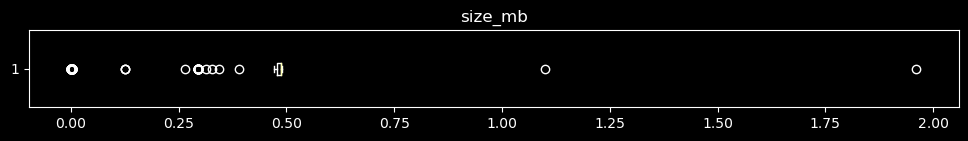

Number of results in lower quartile: 1658 (11.86%)
Number of results in inner quartile: 12318 (88.12%)
Number of results in upper quartile: 2 (0.01%)

Data in lower size_mb quartile (Limit 5)


,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent,size_mb,status_desc
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396,success
5,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/stores,HTTP/1.1,200,1328,python-requests/2.21.0,0.001266,success
8,97.105.19.58,16/Apr/2019 19:34:52,GET,/,HTTP/1.1,200,42,python-requests/2.21.0,0.000040,success
9,97.105.19.58,16/Apr/2019 19:34:53,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396,success
10,97.105.19.58,16/Apr/2019 19:34:53,GET,/api/v1/items?page=2,HTTP/1.1,200,3659,python-requests/2.21.0,0.003489,success



Data in upper size_mb quartile (Limit 2)


,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent,size_mb,status_desc
0,95.31.18.119,21/Apr/2019 10:02:41,GET,/api/v1/items/,HTTP/1.1,200,1153005,python-requests/2.21.0,1.099591,success
3,97.105.19.58,19/Apr/2019 19:42:41,GET,/api/v1/sales?page=79/,HTTP/1.1,200,2056327,python-requests/2.21.0,1.961066,success


Error: Could not generate box plot for column status_desc. Skipping to next column...


In [17]:
iqr_bounds(df)

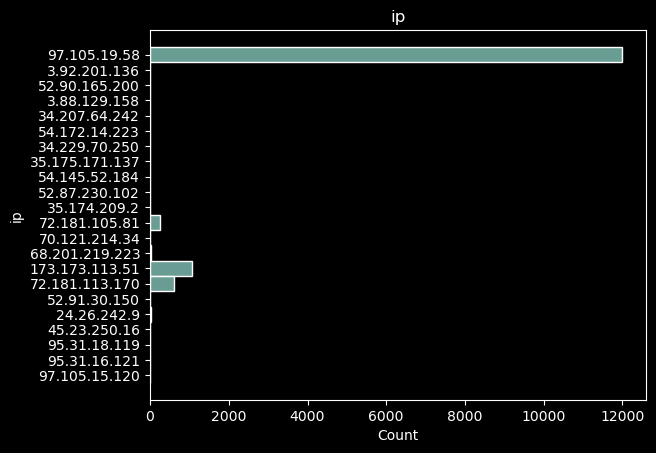

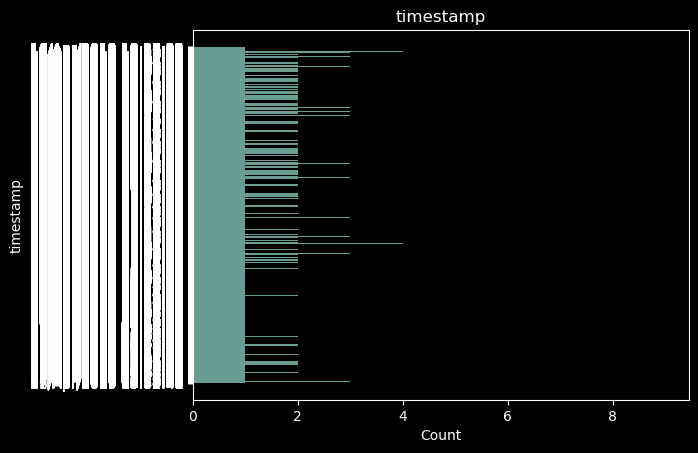

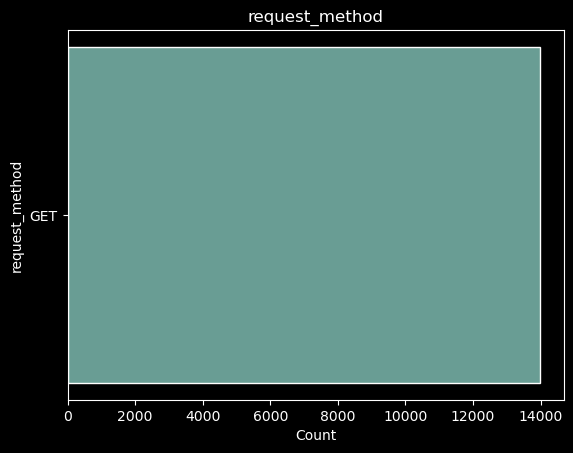

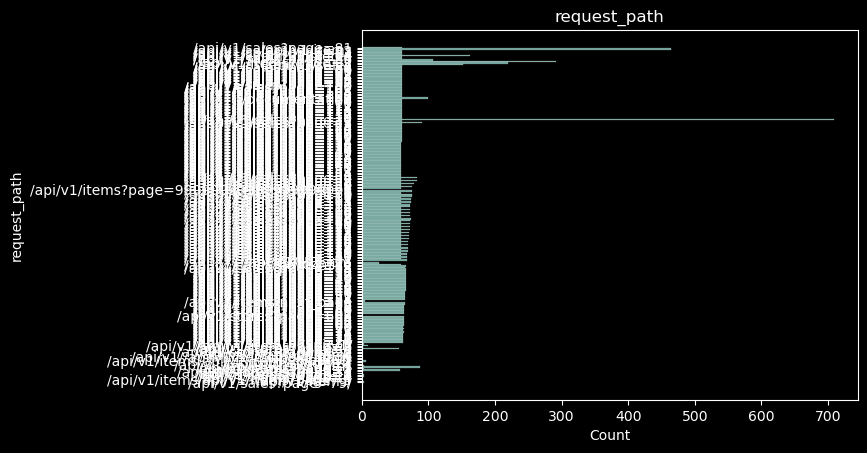

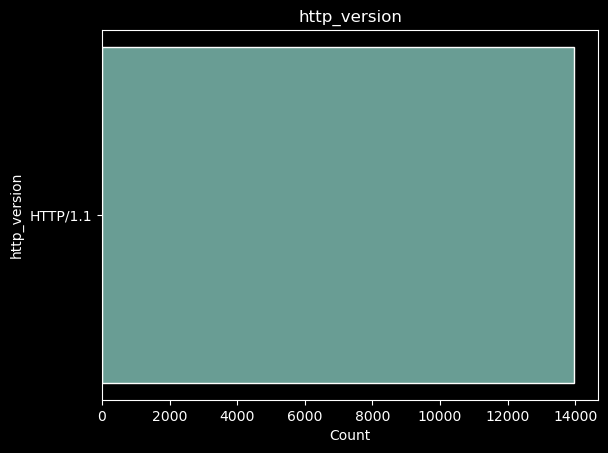

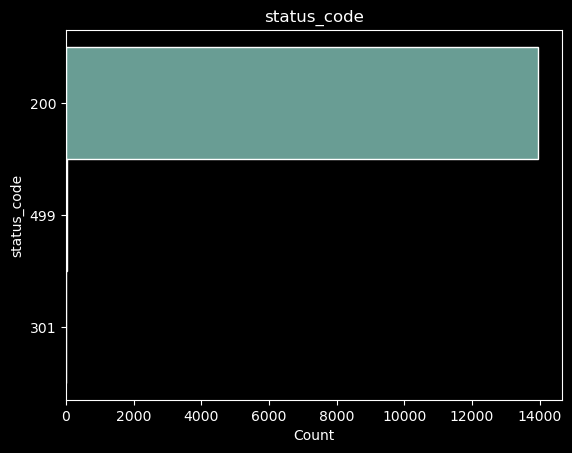

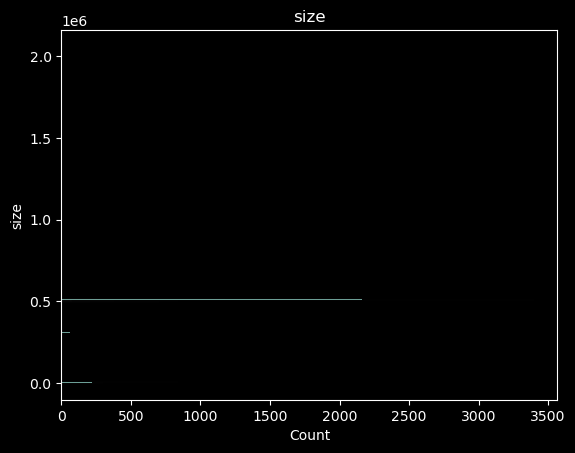

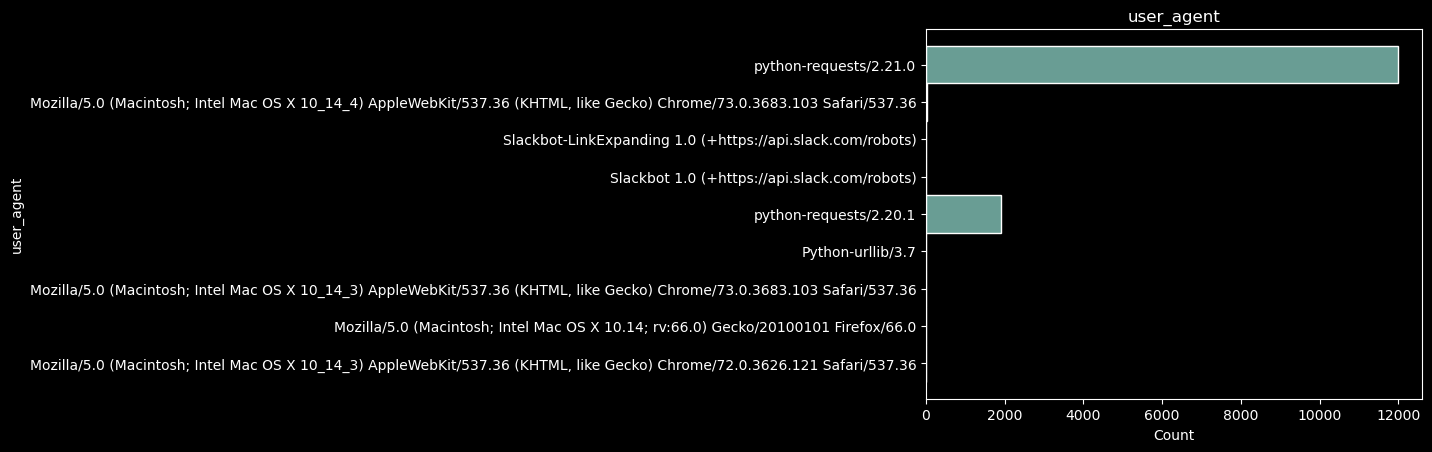

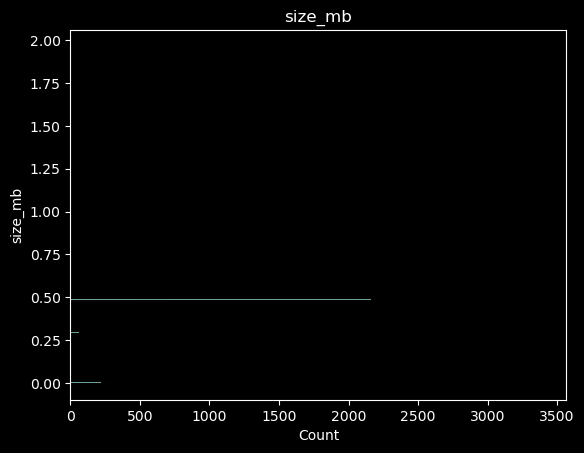

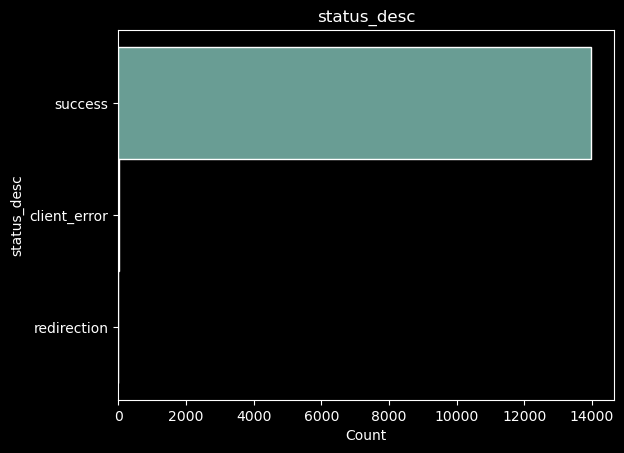

In [18]:
for col in df.columns:
    sns.histplot(data=df,y=col)
    plt.title(col)
    plt.show()

In [19]:
# Make it datetime
df.timestamp = pd.to_datetime(df['timestamp'])

In [20]:
# Make an hour column
df['hour'] = df.timestamp.dt.hour

In [21]:
df['ip'].value_counts()

ip
97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
24.26.242.9          21
35.175.171.137        2
52.87.230.102         2
70.121.214.34         2
52.90.165.200         1
95.31.16.121          1
95.31.18.119          1
45.23.250.16          1
52.91.30.150          1
34.207.64.242         1
3.88.129.158          1
54.172.14.223         1
3.92.201.136          1
35.174.209.2          1
54.145.52.184         1
34.229.70.250         1
97.105.15.120         1
Name: count, dtype: int64

# IP Feature Exploration

In [22]:
check_columns(df)

Total rows: 13978
Total columns: 11


,col_name,dtype,num_unique,num_null,pct_null,unique_values,"range (min, max, mean)"
0,index,int64,13974,0,0.0,"Index([ 0, 1, 2, 3, 4, ...","(0, 13973)"
1,ip,object,22,0,0.0,"[97.105.19.58, 3.92.201.136, 52.90.165.200, 3....",None
2,timestamp,datetime64[ns],9957,0,0.0,"[2019-04-16 19:34:42, 2019-04-16 19:34:44, 201...","(2019-04-16, 2019-04-21)"
3,request_method,object,1,0,0.0,[GET],None
4,request_path,object,220,0,0.0,"[/api/v1/sales?page=81, /api/v1/items, /api/v1...",None
5,http_version,object,1,0,0.0,[HTTP/1.1],None
6,status_code,object,3,0,0.0,"[200, 499, 301]",None
7,size,int64,191,0,0.0,"[512495, 3561, 510103, 510003, 511963, 1328, 5...","(0, 2056327, 450001.91)"
8,user_agent,object,9,0,0.0,"[python-requests/2.21.0, Mozilla/5.0 (Macintos...",None
9,size_mb,float64,191,0,0.0,"[0.4887533187866211, 0.0033960342407226562, 0....","(0.0, 1.9610662460327148, 0.43)"


In [23]:
# Look at all the different IPs. Depending on access, these could be anomalies.

df['ip'].value_counts()

ip
97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
24.26.242.9          21
35.175.171.137        2
52.87.230.102         2
70.121.214.34         2
52.90.165.200         1
95.31.16.121          1
95.31.18.119          1
45.23.250.16          1
52.91.30.150          1
34.207.64.242         1
3.88.129.158          1
54.172.14.223         1
3.92.201.136          1
35.174.209.2          1
54.145.52.184         1
34.229.70.250         1
97.105.15.120         1
Name: count, dtype: int64

In [24]:
# Groupby to get each status code assoicated with each IP, and the ratio that they get each status code

# Could look into where the IP address is located, to see where

df.groupby(['ip', 'status_code']).size()/len(df)

ip              status_code
173.173.113.51  200            0.075762
24.26.242.9     200            0.001502
3.88.129.158    200            0.000072
3.92.201.136    200            0.000072
34.207.64.242   200            0.000072
34.229.70.250   200            0.000072
35.174.209.2    200            0.000072
35.175.171.137  200            0.000143
45.23.250.16    200            0.000072
52.87.230.102   200            0.000143
52.90.165.200   200            0.000072
52.91.30.150    200            0.000072
54.145.52.184   200            0.000072
54.172.14.223   200            0.000072
68.201.219.223  200            0.001502
70.121.214.34   200            0.000143
72.181.105.81   200            0.017599
72.181.113.170  200            0.043712
                499            0.000143
95.31.16.121    301            0.000072
95.31.18.119    200            0.000072
97.105.15.120   301            0.000072
97.105.19.58    200            0.857419
                499            0.001002
dtype: float

In [26]:
status_given_ip = (df.groupby('ip')\
        ['status_code'].value_counts(normalize=True)\
        .rename('status_ratio')\
        .reset_index())

In [47]:
# Apply a map for what each status code is 
status_given_ip['status_desc'] = status_given_ip.status_code.map({'200': 'success', '301': 'redirection', '499': 'client_error'})

In [48]:
status_given_ip.sort_values(by='status_ratio')

,ip,status_code,status_ratio,status_desc
23,97.105.19.58,499,0.001167,client_error
18,72.181.113.170,499,0.003263,client_error
17,72.181.113.170,200,0.996737,success
22,97.105.19.58,200,0.998833,success
21,97.105.15.120,301,1.000000,redirection
20,95.31.18.119,200,1.000000,success
19,95.31.16.121,301,1.000000,redirection
16,72.181.105.81,200,1.000000,success
15,70.121.214.34,200,1.000000,success
14,68.201.219.223,200,1.000000,success


### Spam Requests / DOS

In [29]:
# Find all requests with less than 2 seconds between
df['time_between'] = df.groupby('ip').timestamp.diff().dt.seconds.fillna(value=0)

In [41]:
# Group by IP, then only show requests with 'time_between' less than X
df.groupby('ip').filter(lambda x: x['time_between'].max() < 2)

,index,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent,size_mb,status_desc,hour,status_ratio,time_between
223,223,3.92.201.136,2019-04-16 19:39:14,GET,/,HTTP/1.1,200,42,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000040,success,19,1.0,0.0
224,224,52.90.165.200,2019-04-16 19:39:15,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),0.000154,success,19,1.0,0.0
318,318,3.88.129.158,2019-04-16 19:40:32,GET,/api/v1/items,HTTP/1.1,200,3561,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.003396,success,19,1.0,0.0
320,320,34.207.64.242,2019-04-16 19:40:33,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),0.000154,success,19,1.0,0.0
324,324,54.172.14.223,2019-04-16 19:40:36,GET,/api/v1/,HTTP/1.1,200,162,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000154,success,19,1.0,0.0
325,325,34.229.70.250,2019-04-16 19:40:37,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),0.000154,success,19,1.0,0.0
7829,7829,54.145.52.184,2019-04-16 21:22:22,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),0.000154,success,21,1.0,0.0
8830,8830,35.174.209.2,2019-04-16 21:38:57,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),0.000154,success,21,1.0,0.0
11959,11959,70.121.214.34,2019-04-17 01:25:07,GET,/,HTTP/1.1,200,42,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000040,success,1,1.0,0.0
11960,11960,70.121.214.34,2019-04-17 01:25:07,GET,/favicon.ico,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000154,success,1,1.0,0.0


In [44]:
# Convert the 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Calculate time differences within each group
df['time_between'] = df.groupby('ip')['timestamp'].diff().fillna(pd.Timedelta(seconds=0))

# Filter rows with time differences less than 10 seconds (excluding the first row in each group which has a fill value of 0)
rapid_succession = df[df['time_between'] < pd.Timedelta(seconds=10)][df['time_between'] != pd.Timedelta(seconds=0)]

display(rapid_succession)

/var/folders/sn/k1pt9tkj3532_42jfk9zdjhc0000gn/T/ipykernel_90854/479300147.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rapid_succession = df[df['time_between'] < pd.Timedelta(seconds=10)][df['time_between'] != pd.Timedelta(seconds=0)]


,index,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent,size_mb,status_desc,hour,status_ratio,time_between
2,2,97.105.19.58,2019-04-16 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472,success,19,0.998833,0 days 00:00:02
3,3,97.105.19.58,2019-04-16 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377,success,19,0.998833,0 days 00:00:02
4,4,97.105.19.58,2019-04-16 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246,success,19,0.998833,0 days 00:00:02
6,6,97.105.19.58,2019-04-16 19:34:50,GET,/api/v1/sales?page=85,HTTP/1.1,200,510753,python-requests/2.21.0,0.487092,success,19,0.998833,0 days 00:00:02
7,7,97.105.19.58,2019-04-16 19:34:52,GET,/api/v1/sales?page=86,HTTP/1.1,200,510348,python-requests/2.21.0,0.486706,success,19,0.998833,0 days 00:00:02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13965,13965,97.105.19.58,2019-04-17 12:55:08,GET,/api/v1/sales?page=60,HTTP/1.1,200,510123,python-requests/2.21.0,0.486491,success,12,0.998833,0 days 00:00:02
13966,13966,97.105.19.58,2019-04-17 12:55:09,GET,/api/v1/sales?page=67,HTTP/1.1,200,510139,python-requests/2.21.0,0.486506,success,12,0.998833,0 days 00:00:01
13969,13969,97.105.19.58,2019-04-17 12:55:12,GET,/api/v1/sales?page=62,HTTP/1.1,200,511544,python-requests/2.21.0,0.487846,success,12,0.998833,0 days 00:00:03
13971,13971,97.105.19.58,2019-04-17 12:55:13,GET,/api/v1/sales?page=73,HTTP/1.1,200,511781,python-requests/2.21.0,0.488072,success,12,0.998833,0 days 00:00:01
